# Eucalyptus data set

In [1]:
# imports
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io.arff import loadarff
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold
from naivebayes import NaiveBayes
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

plt.style.use('dark_background')
%matplotlib inline

In [2]:
# Load learn data
raw_data = loadarff("data/dataset_194_eucalyptus.arff");
df = pd.DataFrame(raw_data[0])

In [3]:
df.head()

,Abbrev,Rep,Locality,Map_Ref,Latitude,Altitude,Rainfall,Frosts,Year,Sp,PMCno,DBH,Ht,Surv,Vig,Ins_res,Stem_Fm,Crown_Fm,Brnch_Fm,Utility
0,b'Cra',1.0,b'Central_Hawkes_Bay',b'N135_382/137',b'39__38',100.0,850.0,-2.0,1980.0,b'co',1520.0,18.45,9.96,40.0,4.0,3.0,3.5,4.0,3.5,b'good'
1,b'Cra',1.0,b'Central_Hawkes_Bay',b'N135_382/137',b'39__38',100.0,850.0,-2.0,1980.0,b'fr',1487.0,13.15,9.65,90.0,4.5,4.0,3.5,3.5,3.0,b'best'
2,b'Cra',1.0,b'Central_Hawkes_Bay',b'N135_382/137',b'39__38',100.0,850.0,-2.0,1980.0,b'ma',1362.0,10.32,6.50,50.0,2.3,2.5,3.0,3.5,3.0,b'low'
3,b'Cra',1.0,b'Central_Hawkes_Bay',b'N135_382/137',b'39__38',100.0,850.0,-2.0,1980.0,b'nd',1596.0,14.80,9.48,70.0,3.7,3.0,3.3,4.0,3.5,b'good'
4,b'Cra',1.0,b'Central_Hawkes_Bay',b'N135_382/137',b'39__38',100.0,850.0,-2.0,1980.0,b'ni',2088.0,14.50,10.78,90.0,4.0,2.7,3.3,3.0,3.0,b'good'


### Drop Duplicates

In [4]:
df = df.dropna()

In [5]:
df.shape

(641, 20)

In [6]:
df.dtypes

Abbrev       object
Rep         float64
Locality     object
Map_Ref      object
Latitude     object
Altitude    float64
Rainfall    float64
Frosts      float64
Year        float64
Sp           object
PMCno       float64
DBH         float64
Ht          float64
Surv        float64
Vig         float64
Ins_res     float64
Stem_Fm     float64
Crown_Fm    float64
Brnch_Fm    float64
Utility      object
dtype: object

### Initialize data frame for comparison

In [7]:
cols = ["algorithm", "scaler", "val", "accuracy", "precision", "recall", "f1", "total_time (sec)"]
results = pd.DataFrame(columns = cols)

## Custom Implementation

In [8]:
numeric_features = ["Rep", "Altitude", "Rainfall", "Frosts", "Year", "PMCno", "DBH", 
                    "Ht", "Surv", "Vig", "Ins_res", "Stem_Fm", "Crown_Fm", "Brnch_Fm"]
nominal_features = ["Abbrev", "Locality", "Map_Ref", "Latitude", "Sp"]

train, test = train_test_split(df, test_size=0.3, random_state=42, shuffle=True)
X_test = test.drop(['Utility'], axis=1)
y_test = list(test['Utility'])

#### Holdout

In [9]:
# fitting the model
st1 = time.time()
nb = NaiveBayes()
nb.fit(train, 'Utility')

# prediction
predictions = nb.predict(X_test)

st2 = time.time()
total_time = st2-st1

new_row = pd.DataFrame({
    "algorithm": "Custom NB",
    "scaler": "None",
    "val": 'Holdout',
    "accuracy": accuracy_score(y_test, predictions),
    "precision":precision_score(y_test, predictions, average='macro', zero_division=0),
    "recall":recall_score(y_test, predictions, average='macro', zero_division=0),
    "f1": f1_score(y_test, predictions, average='macro', zero_division=0),
    "total_time (sec)": total_time
}, index=[0])

results = pd.concat([new_row, results.loc[:]]).reset_index(drop=True)

In [10]:
results

,algorithm,scaler,val,accuracy,precision,recall,f1,total_time (sec)
0,Custom NB,None,Holdout,0.549223,0.43068,0.468894,0.438098,0.513519


#### Cross Validation

In [11]:
# Perform the CV on our own model

# create the folds
kf5 = KFold(n_splits=5, shuffle=False)

accuracy = 0
precision = 0
recall = 0
f1 = 0

st = time.time()

for train_index, test_index in kf5.split(df):
    
    # create the train/test split properly
    train = df.iloc[train_index]
    test = df.iloc[test_index]
    X_test = test.drop(['Utility'], axis=1)
    y_test = list(test['Utility'])

    # fitting the model
    nb = NaiveBayes()
    nb.fit(train, 'Utility')
    
    # prediction
    predictions = nb.predict(X_test)
    
    accuracy += accuracy_score(y_test, predictions)
    precision += precision_score(y_test, predictions, average='macro', zero_division=0)
    recall += recall_score(y_test, predictions, average='macro', zero_division=0)
    f1 += f1_score(y_test, predictions, average='macro', zero_division=0)
    
et = time.time()    
total_time = et - st

In [12]:
accuracy = accuracy / 5
precision = precision / 5
recall = recall / 5
f1 = f1 / 5

new_row = pd.DataFrame({
    "algorithm": "Custom NB",
    "scaler": "None",
    "val": 'CV',
    "accuracy": accuracy,
    "precision":precision,
    "recall":recall,
    "f1": f1,
    "total_time (sec)": total_time
}, index=[0])

results = pd.concat([new_row, results.loc[:]]).reset_index(drop=True)

In [13]:
results

,algorithm,scaler,val,accuracy,precision,recall,f1,total_time (sec)
0,Custom NB,None,CV,0.366776,0.320501,0.289003,0.232282,2.060718
1,Custom NB,None,Holdout,0.549223,0.430680,0.468894,0.438098,0.513519


## Scikit-learn NB

In [14]:
# holdout

le = LabelEncoder()
nominal_features = ["Abbrev", "Locality", "Map_Ref", "Latitude", "Sp"]

X = df.drop(columns=['Utility'])
y = df['Utility']

for feature in nominal_features:
    X[feature] = le.fit_transform(X[feature])

y = le.fit_transform (y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

st1 = time.time()
gnb = GaussianNB()
gnb.fit(X_train, y_train)

predictions = gnb.predict(X_test)
et2 = time.time()


new_row = pd.DataFrame({
    "algorithm": "Gaussian NB",
    "scaler": "None",
    "val": 'Holdout',
    "accuracy": accuracy_score(y_test, predictions),
    "precision": precision_score(y_test, predictions, average='macro', zero_division=0),
    "recall": recall_score(y_test, predictions, average='macro', zero_division=0),
    "f1": f1_score(y_test, predictions, average='macro', zero_division=0),
    "total_time (sec)": et2 - st1
}, index=[0])

results = pd.concat([new_row, results.loc[:]]).reset_index(drop=True)

In [15]:
results

,algorithm,scaler,val,accuracy,precision,recall,f1,total_time (sec)
0,Gaussian NB,None,Holdout,0.559585,0.460638,0.508969,0.478254,0.004998
1,Custom NB,None,CV,0.366776,0.320501,0.289003,0.232282,2.060718
2,Custom NB,None,Holdout,0.549223,0.430680,0.468894,0.438098,0.513519


In [16]:
# Cross validation on the sklearn NB

X = df.drop(columns=['Utility'])
y = df['Utility']

for feature in nominal_features:
    X[feature] = le.fit_transform(X[feature])

y = le.fit_transform (y)

gnb = GaussianNB()

st = time.time()

accuracy_scores = cross_val_score(gnb, X, y, cv=5, scoring="accuracy")

et = time.time()

precision_scores = cross_val_score(gnb, X, y, cv=5, scoring="precision_macro")
recall_scores = cross_val_score(gnb, X, y, cv=5, scoring="recall_macro")
f1_scores = cross_val_score(gnb, X, y, cv=5, scoring="f1_macro")

D:\TU Wien\Semester 3\ML\Assignment 2\env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\TU Wien\Semester 3\ML\Assignment 2\env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\TU Wien\Semester 3\ML\Assignment 2\env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
new_row = pd.DataFrame({
    "algorithm": "Gaussian NB",
    "scaler": "None",
    "val": 'CV',
    "accuracy": accuracy_scores.mean(),
    "precision": precision_scores.mean(),
    "recall": recall_scores.mean(),
    "f1": f1_scores.mean(),
    "total_time (sec)": et - st
}, index=[0])

results = pd.concat([new_row, results.loc[:]]).reset_index(drop=True)

In [18]:
results

,algorithm,scaler,val,accuracy,precision,recall,f1,total_time (sec)
0,Gaussian NB,None,CV,0.435308,0.401011,0.396140,0.374909,0.025194
1,Gaussian NB,None,Holdout,0.559585,0.460638,0.508969,0.478254,0.004998
2,Custom NB,None,CV,0.366776,0.320501,0.289003,0.232282,2.060718
3,Custom NB,None,Holdout,0.549223,0.430680,0.468894,0.438098,0.513519


## Scikit-learn MLP

#### Holdout

In [19]:
le = LabelEncoder()
nominal_features = ["Abbrev", "Locality", "Map_Ref", "Latitude", "Sp"]

X = df.drop(columns=['Utility'])
y = df['Utility']

for feature in nominal_features:
    X[feature] = le.fit_transform(X[feature])

y = le.fit_transform (y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

st1 = time.time()
mlp = MLPClassifier()
mlp.fit(X_train, y_train)

predictions = mlp.predict(X_test)
et2 = time.time()

# without scaling
new_row = pd.DataFrame({
    "algorithm": "MLP",
    "scaler": "None",
    "val": 'Holdout',
    "accuracy": accuracy_score(y_test, predictions),
    "precision": precision_score(y_test, predictions, average='macro', zero_division=0),
    "recall": recall_score(y_test, predictions, average='macro', zero_division=0),
    "f1": f1_score(y_test, predictions, average='macro', zero_division=0),
    "total_time (sec)": et2 - st1
}, index=[0])

results = pd.concat([new_row, results.loc[:]]).reset_index(drop=True)

In [20]:
# with scaling
sc = StandardScaler()
sc.fit(X_train)

X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

st1 = time.time()
mlp = MLPClassifier()
mlp.fit(X_train, y_train)

predictions = mlp.predict(X_test)
et2 = time.time()

# without scaling
new_row = pd.DataFrame({
    "algorithm": "MLP",
    "scaler": "StandardScaler",
    "val": 'Holdout',
    "accuracy": accuracy_score(y_test, predictions),
    "precision": precision_score(y_test, predictions, average='macro', zero_division=0),
    "recall": recall_score(y_test, predictions, average='macro', zero_division=0),
    "f1": f1_score(y_test, predictions, average='macro', zero_division=0),
    "total_time (sec)": et2 - st1
}, index=[0])

results = pd.concat([new_row, results.loc[:]]).reset_index(drop=True)

D:\TU Wien\Semester 3\ML\Assignment 2\env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [21]:
results

,algorithm,scaler,val,accuracy,precision,recall,f1,total_time (sec)
0,MLP,StandardScaler,Holdout,0.616580,0.611484,0.581157,0.585074,0.572839
1,MLP,None,Holdout,0.326425,0.291379,0.262172,0.253141,0.254051
2,Gaussian NB,None,CV,0.435308,0.401011,0.396140,0.374909,0.025194
3,Gaussian NB,None,Holdout,0.559585,0.460638,0.508969,0.478254,0.004998
4,Custom NB,None,CV,0.366776,0.320501,0.289003,0.232282,2.060718
5,Custom NB,None,Holdout,0.549223,0.430680,0.468894,0.438098,0.513519


#### Cross validation

In [22]:
# without scaling

X = df.drop(columns=['Utility'])
y = df['Utility']

for feature in nominal_features:
    X[feature] = le.fit_transform(X[feature])

y = le.fit_transform (y)

mlp = MLPClassifier()

st = time.time()

accuracy_scores = cross_val_score(mlp, X, y, cv=5, scoring="accuracy")

et = time.time()

precision_scores = cross_val_score(mlp, X, y, cv=5, scoring="precision_macro")
recall_scores = cross_val_score(mlp, X, y, cv=5, scoring="recall_macro")
f1_scores = cross_val_score(mlp, X, y, cv=5, scoring="f1_macro")

D:\TU Wien\Semester 3\ML\Assignment 2\env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\TU Wien\Semester 3\ML\Assignment 2\env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\TU Wien\Semester 3\ML\Assignment 2\env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
new_row = pd.DataFrame({
    "algorithm": "MLP",
    "scaler": "None",
    "val": 'CV',
    "accuracy": accuracy_scores.mean(),
    "precision": precision_scores.mean(),
    "recall": recall_scores.mean(),
    "f1": f1_scores.mean(),
    "total_time (sec)": et - st
}, index=[0])

results = pd.concat([new_row, results.loc[:]]).reset_index(drop=True)

In [24]:
# with scaling
X = df.drop(columns=['Utility'])
y = df['Utility']

for feature in nominal_features:
    X[feature] = le.fit_transform(X[feature])

y = le.fit_transform (y)

mlp = MLPClassifier()
clf = make_pipeline(StandardScaler(), mlp)

st = time.time()

accuracy_scores = cross_val_score(clf, X, y, cv=5, scoring="accuracy")

et = time.time()

precision_scores = cross_val_score(clf, X, y, cv=5, scoring="precision_macro")
recall_scores = cross_val_score(clf, X, y, cv=5, scoring="recall_macro")
f1_scores = cross_val_score(clf, X, y, cv=5, scoring="f1_macro")

D:\TU Wien\Semester 3\ML\Assignment 2\env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\TU Wien\Semester 3\ML\Assignment 2\env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\TU Wien\Semester 3\ML\Assignment 2\env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\TU Wien\Semester 3\ML\Assignment 2\env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\T

In [25]:
new_row = pd.DataFrame({
    "algorithm": "MLP",
    "scaler": "StandardScaler",
    "val": 'CV',
    "accuracy": accuracy_scores.mean(),
    "precision": precision_scores.mean(),
    "recall": recall_scores.mean(),
    "f1": f1_scores.mean(),
    "total_time (sec)": et - st
}, index=[0])

results = pd.concat([new_row, results.loc[:]]).reset_index(drop=True)

In [26]:
# sort results by accuracy
results.sort_values(by="accuracy", ascending=False)

,algorithm,scaler,val,accuracy,precision,recall,f1,total_time (sec)
2,MLP,StandardScaler,Holdout,0.616580,0.611484,0.581157,0.585074,0.572839
5,Gaussian NB,None,Holdout,0.559585,0.460638,0.508969,0.478254,0.004998
7,Custom NB,None,Holdout,0.549223,0.430680,0.468894,0.438098,0.513519
0,MLP,StandardScaler,CV,0.454118,0.544141,0.444773,0.448370,3.159436
4,Gaussian NB,None,CV,0.435308,0.401011,0.396140,0.374909,0.025194
6,Custom NB,None,CV,0.366776,0.320501,0.289003,0.232282,2.060718
3,MLP,None,Holdout,0.326425,0.291379,0.262172,0.253141,0.254051
1,MLP,None,CV,0.271536,0.316765,0.322117,0.216686,1.328717


## Plots based on tabular data

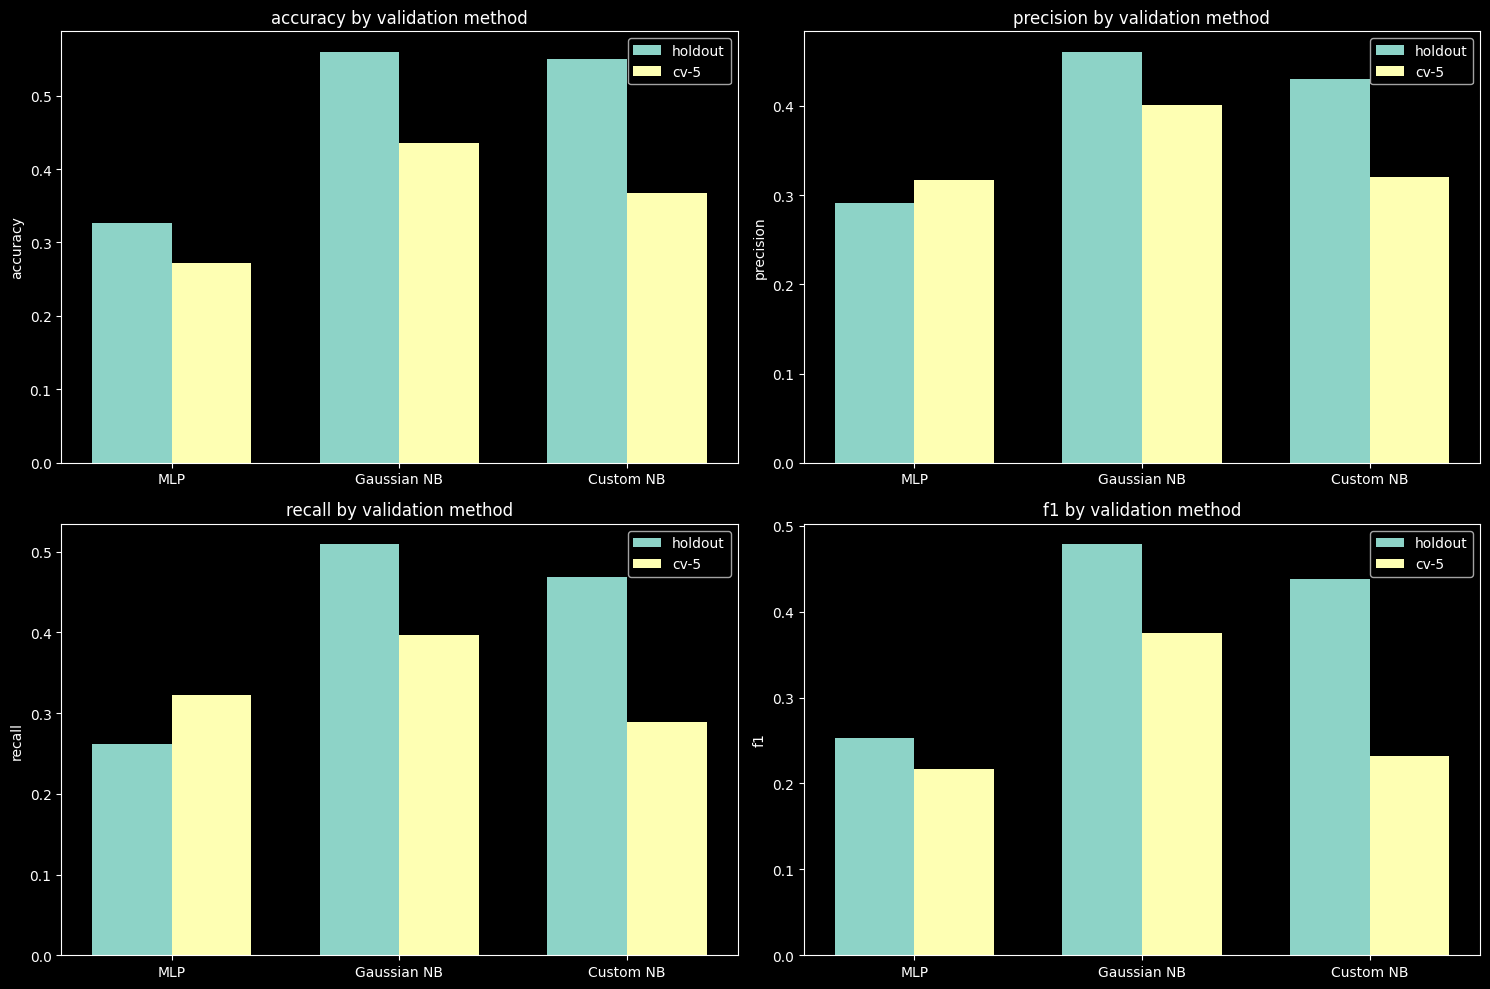

In [27]:
labels = ['MLP', 'Gaussian NB', 'Custom NB']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

results_comp_hw = results.loc[results['scaler'] == 'None']

fig, ax = plt.subplots(2,2)
fig.set_size_inches(15, h=10)
for i in range(2):
    for j in range(2):
        
        metric_idx = 3 + i*2 + j
        metric_name = results.columns[metric_idx]

         
        rects1 = ax[i,j].bar(x - width/2, results_comp_hw.loc[results_comp_hw['val'] == 'Holdout', metric_name], width, label='holdout')
        rects2 = ax[i,j].bar(x + width/2, results_comp_hw.loc[results_comp_hw['val'] == 'CV', metric_name], width, label='cv-5')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax[i,j].set_ylabel(metric_name)
        ax[i,j].set_title(f'{metric_name} by validation method')
        ax[i,j].set_xticks(x)
        ax[i,j].set_xticklabels(labels)
        ax[i,j].legend()

        fig.tight_layout()

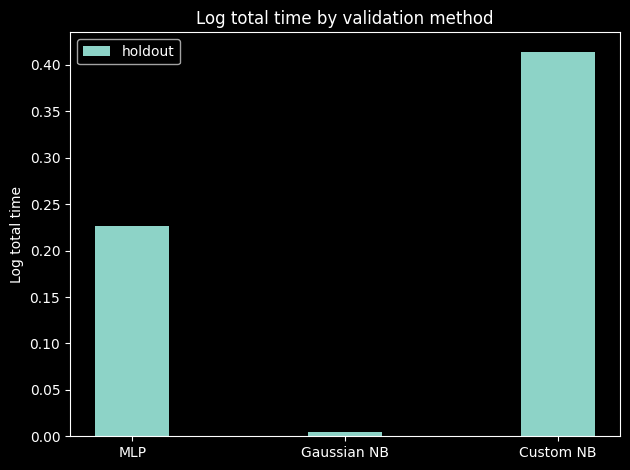

In [28]:
fig, ax = plt.subplots()
rects1 = ax.bar(x , np.log(1 + results_comp_hw.loc[results_comp_hw['val'] == 'Holdout', 'total_time (sec)']), width, label='holdout')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Log total time')
ax.set_title(f'Log total time by validation method')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()